# Data Preparation
### Training a Neural Network to identify the best M3 Combo
By Zach Shelton
5/13/21


In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan

In [1]:
from __future__ import print_function, division
import uproot
import numpy as np
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import coffea.hist as hist
import matplotlib.pyplot as plt
import awkward1 as ak
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

In [33]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events = NanoEventsFactory.from_root(files,schemaclass=HackSchema).events()

In [34]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4)
tightJet = jets[jetSel]
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final = events[eventSel]

In [35]:
#G = Global index of particles - Artifact from Coffea/NanoAOD Tools
print(len(final))

1034882


In [36]:
tightJet.genJetIdx[2]
print(events.GenPart)

[[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]


In [37]:
genPart = final.GenPart
tops = genPart[abs(genPart.pdgId)==6]
#The isLastCopy Flag filters out copy Genparticles:
tops = tops[tops.hasFlags('isLastCopy')]
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
#t_events is the lone bottom, W_events is the -> two jets
#select the hadronically decaying W
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)
#print(qqb)
#HadW is mask for Quark deacying W boson
hadW = ak.num(W_Events,axis=2)==2
#filters out t_events that have a hadronically decayign W Boson
hadB = t_Events[hadW]
hadB = ak.flatten(hadB,axis=2)
W_quarks = W_Events[hadW]
W_quarks = ak.flatten(W_quarks,axis=2)
#concatentating these two arrays make an array of events with the correctly decaying GenParticles.
qqb = ak.concatenate([hadB,W_quarks],axis=1)

In [40]:
#Filtering Out events with extra tops
final=final[(ak.count(qqb.pdgId,axis=1)==3)]
finaljets=final.Jet
qqb=qqb[(ak.count(qqb.pdgId,axis=1)==3)]
#Implementing Tight Jet Cuts on Training Data
finaljetSel=(abs(finaljets.eta)<2.4)&(finaljets.pt>30)
finalJets=finaljets[finaljetSel]
matchedGenJets=qqb.nearest(final.GenJet)
print(matchedGenJets.eta[0:3])
print(matchedGenJets.partonFlavour[0:3])
print(qqb.pdgId[0:3])
matchedJets=matchedGenJets.nearest(finalJets)
print(len(ak.flatten(matchedJets)))
print(len(ak.flatten(matchedJets[(abs(matchedJets.eta)<2.4)])))

[[0.427, 0.29, 1.42], [1.05, 0.703, 1.05], [-1.04, -0.225, 0.735]]
[[5, 2, -1], [-3, 4, -3], [-5, 1, -2]]
[[5, 2, -1], [5, 4, -3], [-5, 1, -2]]
3035748
3035748


In [41]:
test=matchedJets.genJetIdx
combs=ak.combinations(finalJets,3,replacement=False)
t1=(combs['0'].genJetIdx==test[:,0])|(combs['0'].genJetIdx==test[:,1])|(combs['0'].genJetIdx==test[:,2])
t2=(combs['1'].genJetIdx==test[:,0])|(combs['1'].genJetIdx==test[:,1])|(combs['1'].genJetIdx==test[:,2])
t3=(combs['2'].genJetIdx==test[:,0])|(combs['2'].genJetIdx==test[:,1])|(combs['2'].genJetIdx==test[:,2])
t=t1&t2&t3
trutharray=ak.flatten(t)
print(len(trutharray))

11121831


In [44]:
from pprint import pprint
print(t1[0])
print(t2[0])
print(t3[0])
print(t[0])

[True, True, True, True, True, True, False, False, False, False]
[False, False, False, False, False, True, False, False, True, True]
[False, True, True, True, True, True, True, True, True, True]
[False, False, False, False, False, True, False, False, False, False]


In [609]:
from matplotlib import pyplot as plt 

In [45]:
jetcombos=ak.flatten(combs)
genpart_vals=ak.combinations(qqb,3)
good_vals=jetcombos[trutharray]
bad_vals=jetcombos[np.invert(trutharray)]
genreco=genpart_vals['0']+genpart_vals['1']+genpart_vals['2']

In [46]:
print(len(good_vals))
print(len(bad_vals))

634135
10487696


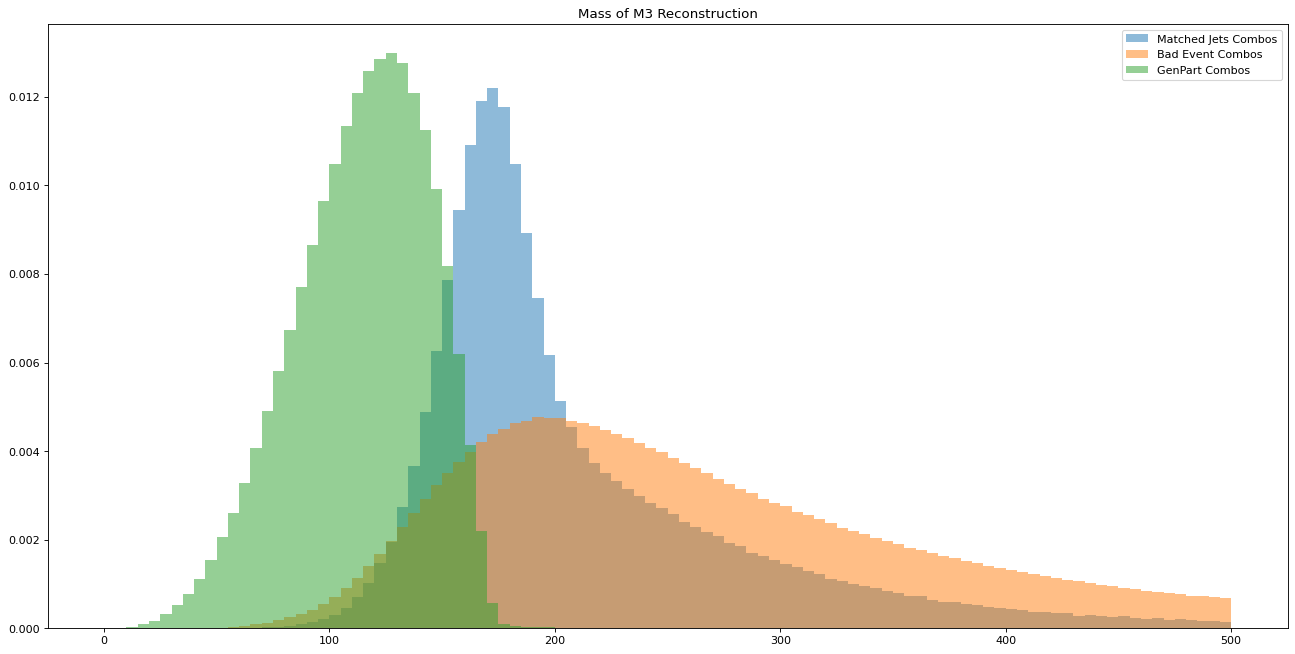

In [47]:
import matplotlib.pyplot as plt
bins1=[]
n=0
while n*5<=500:
    bins1.append(n*5)
    n+=1
plt.figure(figsize=(20,10),dpi=80)
greco=good_vals['0']+good_vals['1']+good_vals['2']
breco=bad_vals['0']+bad_vals['1']+bad_vals['2']
genreco=genpart_vals['0']+genpart_vals['1']+genpart_vals['2']
plt.hist(greco.mass,alpha=.5,density=True,bins=bins1)
plt.hist(breco.mass,alpha=.5,density=True,bins=bins1)
plt.hist(ak.flatten(genreco.mass),alpha=.5,density=True,bins=bins1)
plt.legend(["Matched Jets Combos","Bad Event Combos","GenPart Combos"])
plt.title("Mass of M3 Reconstruction")
plt.show()

In [50]:
j1,j2,j3=ak.unzip(jetcombos)
dR1_2=j1.delta_r(j2)
dR1_3=j1.delta_r(j3)
dR2_3=j2.delta_r(j3)
j1b_tag=j1.btagCSVV2
j2b_tag=j1.btagCSVV2
j3b_tag=j1.btagCSVV2
j1area=j1.area
j2area=j2.area
j3area=j3.area
j1p4=ak.zip({"pt":j1.pt,"phi":j1.phi,"eta":j1.eta,"mass":j1.mass},with_name="PtEtaPhiMLorentzVector")
j2p4=ak.zip({"pt":j2.pt,"phi":j2.phi,"eta":j2.eta,"mass":j2.mass},with_name="PtEtaPhiMLorentzVector")
j3p4=ak.zip({"pt":j3.pt,"phi":j3.phi,"eta":j3.eta,"mass":j2.mass},with_name="PtEtaPhiMLorentzVector")
processedMLdata=ak.zip({"j1p4":j1p4,"j2p4":j2p4,"j3p4":j3p4,
                        "dR12":dR1_2,"dR13":dR1_3,"dR23":dR2_3,
                       "j1btag":j1b_tag,"j2btag":j2b_tag,"j3btag":j3b_tag,
                       "j1area":j1area,"j2area":j2area,"j3area":j3area})

In [52]:
df=ak.to_pandas(processedMLdata)
df.to_csv("data/Total_ML_Training_data.csv",index=False)
vf=ak.to_pandas(trutharray)
vf.to_csv("data/Total_Valid_data.csv",index=False)

## Dataset Parameters:
* 4-Vector
* Area
* Delta-r 1-2
* Delta-r 2-3
* Delta-r 1-3
* B-tag

## Notes for Zach to keep up

create JIT compiler

Seperate values, weights and triggers(X)
read these into tensors for Keras(X)
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
Should I use Keras or PyTorch

# Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable